# Question Pairs

## Business Problem Context

Given an FAQ database, if we can match a new question to the closest known question, within some threshold of certainty, we can provide a known answer to this new question.

Therefore, a key capability in a knowledge application is the ability to determine the similarity between two questions.

In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
import sys
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [2]:
np.warnings.filterwarnings('ignore')

In [3]:
sys.path.append('../..')
sys.path.append('/Users/d777710/src/Python/spaCy')
sys.path.append('/Users/d777710/src/Python/spaCy/examples/keras_parikh_entailment')

## Dataset - Quora Question Pairs

A dataset created for a [Kaggle competition](https://www.kaggle.com/c/quora-question-pairs).

* Duplicates proportion: 36.9% in train, 17.4% in test
* Number of question pairs: ~400k in train, ~2.3M in test
* ~80% of test dataset contains fake question pairs, such that we can’t hand label test question pairs (avoid cheating)
* ~530k unique questions in train dataset
* ~110k questions appear multiple times in train and test datasets
* Questions which contains:
  * Question mark: 99.87%
  * [math] tags: 0.12%
  * Capitalized first letter: 99.81%
  * Capital letters: 99.95%
  * Numbers: 11.83%

### Load the dataset

In [ ]:
import keras_model.decomposable_attention as dec_attn
import keras_model.decomposable_attention.util as dec_attn_util

In [4]:
if os.path.exists('train_df.pkl'):
    train_df = pd.read_pickle('train_df.pkl')
else:
    train_df, _ = dec_attn.load_question_pairs_dataset()

### Common hyperparameters

In [41]:
max_len = 60

### Common functions

In [ ]:
def batch_iter(data, batch_size, shuffle=True):
    data_size = len(data)
    n_batches = int(data_size / batch_size) + 1
    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_data = data[shuffle_indices]
    else:
        shuffled_data = data
        
    for i in range(n_batches):
        start_i = i * batch_size
        end_i = min((i + 1) * batch_size, data_size)
        yield shuffled_data[start_i:end_i]

### Explore the dataset

In [44]:
train_df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_binned,q2_binned,q1_encoded,q1_length,q2_encoded,q2_length,lsa_cosine_similarity
107142,173615,17297,How does one get many views on a Quora question?,How do you get so many views on Quora?,1,10,9,"(5, 10]","(5, 10]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,0.622637
253480,368033,368034,What was your favorite road trip?,What are some of your favorite road trip games?,0,6,9,"(5, 10]","(5, 10]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,0.996812
293641,415432,121619,What countries have extradition treaties with ...,Which countries that Singapore doesn't have an...,0,7,10,"(5, 10]","(5, 10]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,0.846337
312673,437156,437157,Is the Aligno surname Italian?,Any body know …Anand motor products …how is th...,0,5,10,NaN,"(5, 10]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,0.120422
97689,8639,134638,Why Cyrus Mistry has been removed from Tata Gr...,Why was Cyrus Mistry removed as the Chairman o...,1,9,11,"(5, 10]","(10, 20]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11,0.804597


In [ ]:
q1_lens = train_df.question1.apply(lambda x: len(re.split(r'\s+', x.strip()))).values
q2_lens = train_df.question2.apply(lambda x: len(re.split(r'\s+', x.strip()))).values
train_df = train_df.assign(q1_len=q1_lens, q2_len=q2_lens)
lens = np.vstack([q1_lens, q2_lens])

In [ ]:
max_len = lens.max()
print('max_len:', max_len)

In [ ]:
max(q1_lens)

In [ ]:
train_df.q1_len.hist()

In [ ]:
max(q2_lens)

In [ ]:
train_df.q2_len.hist()

In [ ]:
bins = [5, 10, 20, 30, 40, 50, 60, 70, 100, 228]
train_df = train_df.assign(q1_binned=pd.cut(train_df.q1_len, bins), q2_binned=pd.cut(train_df.q2_len, bins))

In [ ]:
train_df.groupby(train_df.q1_binned).size()

In [ ]:
train_df.groupby(train_df.q2_binned).size()

In [ ]:
train_df.head(10)

In [ ]:
embeddings, word2idx, _, _ = dec_attn.load_embeddings('../../keras_model/decomposable_attention/ft.vec')

In [ ]:
train_df = dec_attn.preprocess(train_df, word2idx, max_len)

In [ ]:
train_df.head()

In [ ]:
train_df.iloc[0].question1

In [ ]:
print(train_df.iloc[0].q1_encoded[-20:])

In [ ]:
counts_by_label = train_df.groupby('is_duplicate').qid1.count()

In [ ]:
counts_by_label

In [ ]:
counts_by_label.loc[1] / counts_by_label.sum()

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes()
counts_by_label.plot.bar(ylim=0)

### Split to create the test set

In [ ]:
if os.path.exists('test_df.pkl'):
    test_df = pd.read_pickle('test_df.pkl')
else:
    train_df, test_df = train_test_split(train_df, test_size=0.1, shuffle=True)

### Save the training and test sets

In [ ]:
if not os.path.exists('train_df.pkl'):
    train_df.to_pickle('train_df.pkl')
    
if not os.path.exists('test_df.pkl'):
    test_df.to_pickle('test_df.pkl')

### Preprocess the test set

In [ ]:
dec_attn_embeddings_path = '../../keras_model/decomposable_attention/ft.vec'
embeddings, word2idx, _, _ = dec_attn_util.load_embeddings(dec_attn_embeddings_path)

In [ ]:
test_df = dec_attn_util.preprocess(test_df, word2idx, max_len)

## Experiment 1 - Decomposable Attention Model

We can think of question similarity as an entailment task.

Textual entailment (TE) in natural language processing is a directional relation between text fragments. The relation holds whenever the truth of one text fragment follows from another text. In the TE framework, the entailing and entailed texts are termed text (t) (or premise (p)) and hypothesis (h), respectively.

The winning solution to the Quora challenge ended up using a decomposable attention model, a siamese network, an enhanced sequential inference model, and more. These were stacked together to form the final classifier.

This model architecture from [A Decomposable Attention Model for Natural Language Inference](https://arxiv.org/pdf/1606.01933.pdf), Parikh, et al., provides an efficient way to calculate entailment with attention.

In [ ]:
from keras.models import load_model
from keras_model.layers import MaskedGlobalAveragePooling1D, MaskedGlobalMaxPooling1D

In [ ]:
dec_attn_model_path = '../../keras_model/decomposable_attention/decom_attn_checkpoint'
dec_attn_model = load_model(dec_attn_model_path, custom_objects={
            'MaskedGlobalAveragePooling1D': MaskedGlobalAveragePooling1D(),
            'MaskedGlobalMaxPooling1D': MaskedGlobalMaxPooling1D()
        })

In [ ]:
batch_size = 256

In [ ]:
preds = dec_attn_model.predict([np.asarray(test_df.q1_encoded.tolist()),
                                np.asarray(test_df.q2_encoded.tolist())],
                               batch_size=batch_size, verbose=1)

In [ ]:
y_pred = [int(x[0] > .5) for x in preds]
y_true = test_df.is_duplicate.tolist()

In [ ]:
acc = accuracy_score(y_true, y_pred)
ll = log_loss(y_true, y_pred)

In [ ]:
print('Decomposable Attn model accuracy: {:.2f}, log_loss: {:.2f}'.format(acc, ll))

## Experiment 2 - Decomposable Attention Model from Spacy team

Mainly to validate my version of the model above.

In [ ]:
import spacy
from spacy_hook import KerasSimilarityShim

In [40]:
max_len = 50

In [ ]:
nlp = spacy.load('en_vectors_web_lg')
nlp.add_pipe(KerasSimilarityShim.load(nlp.path / 'similarity', nlp, max_len))

In [ ]:
docs1 = test_df.question1.tolist()
docs2 = test_df.question2.tolist()
labels = test_df.is_duplicate.tolist()
y_pred = []
for doc1, doc2, label in zip(docs1, docs2, labels):
    d1 = nlp(doc1)
    d2 = nlp(doc2)
    sim, _ = d1.similarity(d2)
    
    # sim is returning one of ["entailment", "contradiction", "neutral"]
    # however my label is one of [0, 1] representing "is_duplicate" or not
    # therefore I need to extract the index from the prediction to get my label
    y_pred.append(KerasSimilarityShim.entailment_types.index(sim))

In [ ]:
y_true = test_df.is_duplicate.tolist()
acc = accuracy_score(y_true, y_pred)
ll = log_loss(y_true, y_pred)
print('Decomposable Attn model accuracy: {:.2f}, log_loss: {:.2f}'.format(acc, ll))

## Experiment 3 - Siamese CNN

A Siamese CNN is built by combining two CNNs (which are often identical), then running
some distance metric on their outputs.

## Experiment 4 - LightGBM and custom features

LightGBM is a gradient boosting framework that uses tree based learning algorithm.

LightGBM grows the tree vertically while other algorithms grow trees horizontally. In other words, LightGBM grows the tree leaf-wise while other algorithms grow level-wise. It will choose the leaf with the maximum delta loss to grow. When growing the same branch, leaf-wise algorithm can reduce more loss than a level-wise algorithm.

In [74]:
from fuzzywuzzy import fuzz
import gensim
from pyemd import emd
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from scipy.stats import skew, kurtosis
from sklearn.metrics.pairwise import linear_kernel
import spacy

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('../../../data/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
norm_model = gensim.models.KeyedVectors.load_word2vec_format('../../../data/word2vec/GoogleNews-vectors-negative300.bin', binary=True)
norm_model.init_sims(replace=True)

In [75]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
def sent2vec(tokens):
    words = [w for w in tokens if w.isalpha()]
    W = []
    for w in words:
        try:
            W.append(model[w])
        except:
            continue
            
    W = np.array(W)
    v = W.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

### Preprocess

In [76]:
# remove stop words and convert to lower case
train_df = train_df.assign(
    q1_nostop=train_df.question1.apply(lambda x: [w.text.lower() for w in nlp(x) if not w.is_stop]),
    q2_nostop=train_df.question2.apply(lambda x: [w.text.lower() for w in nlp(x) if not w.is_stop]))

In [ ]:
train_df.head()

In [ ]:
train_df.iloc[1].question1

In [ ]:
train_df.iloc[1].q1_nostop

### Save preprocessed dataframe

In [ ]:
train_df.to_pickle('train_df_nostop.pkl')

### Load preprocessed dataframe

In [ ]:
train_df = pd.read_pickle('train_df_nostop.pkl')

### Feature engineering

**Word Mover's Distance**

Word Mover's Distance (WMD) is a method that computes the "distance" between two documents, even when they have no words in common. It uses word2vec vector embeddings of words. It's been shown to outperform many state-of-the-art methods in k-nearest neighbors classification.

This method was introduced in the article [From Word Embeddings To Document Distances](http://proceedings.mlr.press/v37/kusnerb15.pdf) by Matt Kusner, et al.

See this [tutorial](https://markroxor.github.io/gensim/static/notebooks/WMD_tutorial.html) for more information.

** Normalized WMD**

When using the wmdistance method it is beneficial to normalize the word2vec vectors first so they all have equal length. To do this, simply call model.init_sims(replace=True) and Gensim will take care of that for you.

Usually, one measures the distance between two word2vec vectors using the cosine distance, which measures the angle between vectors. WMD, on the other hand, uses the Euclidean distance. The Euclidean distance between two vectors might be large because their lengths differ, but the cosine distance is small because the angle between them is small. We can mitigate some of this by normalizing the vectors.

In [ ]:
train_df = train_df.assign(
    wmd=train_df.apply(lambda x: model.wmdistance(x.q1_nostop, x.q2_nostop), axis=1),
    norm_wmd=train_df.apply(lambda x: norm_model.wmdistance(x.q1_nostop, x.q2_nostop), axis=1))

**Distance measures**

*cosine*: the cosine distance between 1-D arrays $u$ and $v$ is defined as:

$$1 - \frac{u \cdot v}{\lVert u\rVert_2 \lVert v\rVert_2}$$

*cityblock*: the Manhattan distance between two 1-D arrays $u$ and $v$, which is defined as:

$$\sum_{i}\lvert u_i - v_i\rvert$$

*jaccard*: the Jaccard-Needham dissimilarity between 1-D boolean arrays $u$ and $v$ is defined as:

$$\frac{c_{TF} + c_{FT}}{c_{TT} + c_{FT} + c_{TF}}$$

where $c_ij$ is the number of occurrences of $u[k] = i$ and $v[k] = j$ for $k < n$.

*canberra*: the Canberra distance between two 1-D arrays is defined as:

$$d(u, v) = \sum_{i}\frac{\lvert u_i - v_i\rvert}{\lvert u_i\rvert + \lvert v_i\rvert}$$

*euclidean*: the Euclidean distance between 1-D arrays $u$ and $v$ is defined as:

$${||u-v||}_2$$
$$\left(\sum{(w_i |(u_i - v_i)|^2)}\right)^{1/2}$$

where $w$ is the weights for each value in $u$ and $v$. Default is None, which gives each value a weight of 1.0.

*minkowski*: the Minkowski distance between 1-D arrays $u$ and $v$ is defined as:

$${||u-v||}_p = (\sum{|u_i - v_i|^p})^{1/p}$$
$$\left(\sum{w_i(|(u_i - v_i)|^p)}\right)^{1/p}$$

where $w$ is the weights for each value in $u$ and $v$. Default is None, which gives each value a weight of 1.0.

*braycurtis*: Bray-Curtis distance is defined as:

$$\sum{|u_i-v_i|} / \sum{|u_i+v_i|}$$

**Skew and Kurtosis**

*skew*: For normally distributed data, the skewness should be about 0. For unimodal continuous distributions, a skewness value > 0 means that there is more weight in the right tail of the distribution.

*kurtosis*: Kurtosis is the fourth central moment divided by the square of the variance. If Fisher’s definition is used, then 3.0 is subtracted from the result to give 0.0 for a normal distribution. If bias is False then the kurtosis is calculated using k statistics to eliminate bias coming from biased moment estimators.

In [ ]:
q1_vectors = np.zeros((len(train_df), 300))
q2_vectors = np.zeros((len(train_df), 300))

for i, q in tqdm(enumerate(train_df.question1.values)):
    q1_vectors[i, :] = sent2vec(q)

for i, q in tqdm(enumerate(train_df.question2.values)):
    q2_vectors[i, :] = sent2vec(q)
    
train_df = train_df.assign(
    cosine_distance=[cosine(x, y) for x, y in zip(np.nan_to_num(q1_vectors), np.nan_to_num(q2_vectors))],
    cityblock_distance=[cityblock(x, y) for x, y in zip(np.nan_to_num(q1_vectors), np.nan_to_num(q2_vectors))],
    jaccard_distance=[jaccard(x, y) for x, y in zip(np.nan_to_num(q1_vectors), np.nan_to_num(q2_vectors))],
    canberra_distance=[canberra(x, y) for x, y in zip(np.nan_to_num(q1_vectors), np.nan_to_num(q2_vectors))],
    euclidean_distance=[euclidean(x, y) for x, y in zip(np.nan_to_num(q1_vectors), np.nan_to_num(q2_vectors))],
    minkowski_distance=[minkowski(x, y) for x, y in zip(np.nan_to_num(q1_vectors), np.nan_to_num(q2_vectors))],
    braycurtis_distance=[braycurtis(x, y) for x, y in zip(np.nan_to_num(q1_vectors), np.nan_to_num(q2_vectors))],
    skew_q1vec=[skew(x) for x in np.nan_to_num(q1_vectors)],
    skew_q2vec=[skew(x) for x in np.nan_to_num(q2_vectors)],
    kurtosis_q1vec=[kurtosis(x) for x in np.nan_to_num(q1_vectors)],
    kurtosis_q2vec=[kurtosis(x) for x in np.nan_to_num(q2_vectors)]
)

In [ ]:
train_df.head()

**More features:**

* Length
* Difference in lengths between questions
* Char length (without spaces)
* Number of words
* Number of words in common
* Various Levenshtein Distance ratios

In [ ]:
train_df = train_df.assign(
    q1_len=train_df.question1.apply(lambda x: len(str(x))),
    q2_len=train_df.question2.apply(lambda x: len(str(x))),
    q1_char_len=train_df.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', ''))))),
    q2_char_len=train_df.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', ''))))),
    q1_num_words=train_df.question1.apply(lambda x: len(str(x).split())),
    q2_num_words=train_df.question2.apply(lambda x: len(str(x).split())),
    num_common_words=train_df.apply(lambda x: len(set(str(x.question1).lower().split()).intersection(set(str(x.question2).lower().split()))), axis=1),
    fuzz_qratio=train_df.apply(lambda x: fuzz.QRatio(str(x.question1), str(x.question2)), axis=1),
    fuzz_wratio=train_df.apply(lambda x: fuzz.WRatio(str(x.question1), str(x.question2)), axis=1),
    fuzz_partial_ratio=train_df.apply(lambda x: fuzz.partial_ratio(str(x.question1), str(x.question2)), axis=1),
    fuzz_partial_token_set_ratio=train_df.apply(lambda x: fuzz.partial_token_set_ratio(str(x.question1), str(x.question2)), axis=1),
    fuzz_partial_token_sort_ratio=train_df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x.question1), str(x.question2)), axis=1),
    fuzz_token_set_ratio=train_df.apply(lambda x: fuzz.token_set_ratio(str(x.question1), str(x.question2)), axis=1),
    fuzz_token_sort_ratio=train_df.apply(lambda x: fuzz.token_sort_ratio(str(x.question1), str(x.question2)), axis=1)
)
train_df = train_df.assign(len_diff=train_df.q1_len - train_df.q2_len)

In [ ]:
train_df.head()

In [ ]:
q_words = ['am', 'are', 'can', 'could', 'did', 'does', 'had', 'has', 'have', 'how', 'is', 'may', 'might',
           'shall', 'was', 'were', 'what', 'where', 'which', 'who', 'why', 'will', 'would']
add_q_words = ['at', 'do', 'from', 'if', 'in', 'on', 'over', 'should', 'to', 'under', 'when']

In [ ]:
train_df = train_df.assign(
    q1_starts_with_q_word=train_df.question1.apply(lambda x: int([w.lower() for w in x.split()][0] in q_words)),
    q2_starts_with_q_word=train_df.question2.apply(lambda x: int([w.lower() for w in x.split()][0] in q_words)),
    q1_starts_with_add_q_word=train_df.question1.apply(lambda x: int([w.lower() for w in x.split()][0] in add_q_words)),
    q2_starts_with_add_q_word=train_df.question2.apply(lambda x: int([w.lower() for w in x.split()][0] in add_q_words)),
    q1_ends_with_q_mark=train_df.question1.apply(lambda x: int(x.endswith('?'))),
    q2_ends_with_q_mark=train_df.question2.apply(lambda x: int(x.endswith('?')))
)

In [ ]:
train_df.head()

**TF-IDF**

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
# Args:
# decode_error: {‘strict’, ‘ignore’, ‘replace’} instruction on what to do if a byte sequence 
#               is given to analyze that contains characters not of the given encoding.
#
# stop_words: If a string, it is passed to _check_stop_list and the appropriate stop list is returned. 
#             ‘english’ is currently the only supported string value.
#
# ngram_range: (tuple[int]) lower and upper boundary of the range of n-values for different 
#              n-grams to be extracted
#
# max_df: (float|int) maximum document frequency (corpus-specific stop words)
#
# min_df: (float|int) minimum document frequency (cutoff)
#
# max_features: (int) selects the top-n most frequently occurring words in the corpus
#
# norm: {‘l1’, ‘l2’, None} Norm used to normalize term vectors.
#
# use_idf: (bool) enable inverse-document-frequency reweighting.
#
# smooth_idf: (bool) Smooth idf weights by adding one to document frequencies, as if an extra 
#             document was seen containing every term in the collection exactly once. Prevents 
#             zero divisions.
#
# sublinear_tf: (bool) apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).
#
# sublinear scaling and inverse document frequency should be turned on (sublinear_tf=True, 
# use_idf=True) to bring the feature values closer to a Gaussian distribution, compensating 
# for LSA’s erroneous assumptions about textual data.
vectorizer = TfidfVectorizer(decode_error='ignore', stop_words='english', ngram_range=(1, 2),
                             max_df=0.5, min_df=2, max_features=10000,
                             norm='l2', use_idf=True, smooth_idf=True,  # defaults
                             sublinear_tf=True)

In [9]:
texts = np.concatenate([train_df.question1.values, train_df.question2.values])
vectorizer = vectorizer.fit(texts)

In [10]:
q1_tfidf = vectorizer.transform(train_df.question1.values)
q2_tfidf = vectorizer.transform(train_df.question2.values)

**Latent Semantic Analysis (LSA)**

All topic models are based on the same basic assumptions:
* Each *document* consists of a mixture of *topics*, and
* Each *topic* consists of a collection of *words*.

In other words, topic models are built around the idea that the semantics of our document are actually being governed by some hidden, or “latent,” variables that we are not observing. As a result, the goal of topic modeling is to uncover these latent variables — *topics* — that shape the meaning of our document and corpus.

The core idea is to take a matrix of what we have — documents and terms (words in the document) — and decompose it into a separate document-topic matrix and a topic-term matrix.

The first step is generating our document-term matrix. Given m documents and n words in our vocabulary, we can construct an m × n matrix A in which each row represents a document and each column represents a word. In the simplest version of LSA, each entry can simply be a raw count of the number of times the j-th word appeared in the i-th document. In practice, however, raw counts do not work particularly well because they do not account for the significance of each word in the document. For example, the word “nuclear” probably informs us more about the topic(s) of a given document than the word “test.”

Consequently, LSA models typically replace raw counts in the document-term matrix with a tf-idf score.

Once we have our document-term matrix A, we can start thinking about our latent topics. Here’s the thing: in all likelihood, $A$ is very sparse, very noisy, and very redundant across its many dimensions. As a result, to find the few latent topics that capture the relationships among the words and documents, we want to perform dimensionality reduction on $A$.

This dimensionality reduction can be performed using truncated SVD. SVD, or singular value decomposition, is a technique in linear algebra that factorizes any matrix $M$ into the product of 3 separate matrices: The $M = U\times S\times V$, where $S$ is a diagonal matrix of the singular values of $M$. Critically, truncated SVD reduces dimensionality by selecting only the $t$ largest singular values, and only keeping the first $t$ columns of $U$ and $V$. In this case, $t$ is a hyperparameter we can select and adjust to reflect the number of topics we want to find.

See [Topic Modeling with LSA, PLSA, LDA & lda2Vec](https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05).

In [22]:
from scipy.sparse import vstack
from scipy.spatial.distance import cosine
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

In [14]:
tfidf = vstack([q1_tfidf, q2_tfidf])

In [19]:
svd_model = TruncatedSVD(n_components=100, algorithm='randomized', n_iter=10)

In [20]:
svd_model = svd_model.fit(tfidf)

In [26]:
len(svd_model.components_)

100

In [24]:
normalizer = Normalizer(copy=False)

In [32]:
q1_svd = normalizer.transform(svd_model.transform(q1_tfidf))
q2_svd = normalizer.transform(svd_model.transform(q2_tfidf))

In [33]:
# Note that `spatial.distance.cosine` computes the distance, not the similarity.
# So you must subtract the value from 1 to get the similarity.
scores = []
for u, v in zip(q1_svd, q2_svd):
    cosine_similarity = 1 - cosine(u, v)
    scores.append(cosine_similarity)

In [37]:
train_df = train_df.assign(lsa_cosine_similarity=scores)

In [65]:
import umap

In [67]:
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(q1_svd)

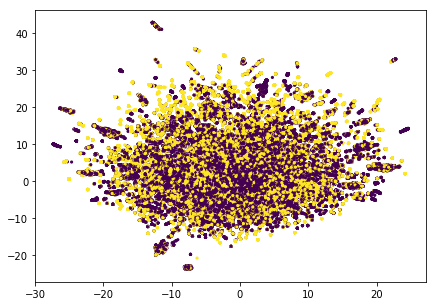

In [69]:
plt.figure(figsize=(7, 5))
plt.scatter(embedding[:, 0], embedding[:, 1], c=train_df.is_duplicate.values, s=10, edgecolor='none')
plt.show()

**Latent Dirichlet Allocation (LDA)**

LDA is a Bayesian version of Probabilistic Latent Semantic Analysis (pLSA). In particular, it uses dirichlet priors for the document-topic and word-topic distributions, lending itself to better generalization.

With LDA, we can extract human-interpretable topics from a document corpus, where each topic is characterized by the words they are most strongly associated with. For example, topic 2 could be characterized by terms such as “oil, gas, drilling, pipes, Keystone, energy,” etc. Furthermore, given a new document, we can obtain a vector representing its topic mixture, e.g. 5% topic 1, 70% topic 2, 10% topic 3, etc. These vectors are often very useful for downstream applications.

In [39]:
from tensorflow.contrib import learn

In [42]:
vocab_processor = learn.preprocessing.VocabularyProcessor(max_len)

In [43]:
vocab_processor.fit(texts)

In [68]:
vocab_processor.vocabulary_._mapping['countries']

17

In [70]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaModel

In [78]:
texts = np.concatenate([train_df.q1_nostop.values, train_df.q2_nostop.values])
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]
lda = LdaModel(common_corpus, num_topics=100, update_every=1, chunksize=10000, passes=1)

In [83]:
common_dictionary.doc2bow(train_df.q1_nostop.values[3])

[(0, 1), (13, 1), (14, 1), (15, 1), (16, 1)]

In [79]:
# Note that `spatial.distance.cosine` computes the distance, not the similarity.
# So you must subtract the value from 1 to get the similarity.
scores = []
for q1, q2 in zip(train_df.question1.values, train_df.question2.values):
    q1_bow = common_dictionary.doc2bow(q1.split())
    q2_bow = common_dictionary.doc2bow(q2.split())
    # `<doc>_lda` is a vector of length num_topics representing 
    # the weighted presence of each topic in the doc
    q1_lda = lda[q1_bow]
    q2_lda = lda[q2_bow]
    cosine_similarity = 1 - cosine(q1_lda, q2_lda)
    scores.append(cosine_similarity)

ValueError: Input vector should be 1-D.

In [ ]:
train_df = train_df.assign(lda_cosine_similarity=scores)

**lda2vec**

lda2vec is an extension of word2vec and LDA that jointly learns word, document, and topic vectors.

With lda2vec, instead of using the word vector directly to predict context words, we leverage a context vector to make the predictions. This context vector is created as the sum of two other vectors: the word vector and the document vector.

**Graph features**

In [ ]:
import ml.doc_similarity.extractor as extractor

In [ ]:
importlib.reload(extractor)

In [ ]:
import ml.doc_similarity.graph_features as graph

In [ ]:
importlib.reload(graph)

In [ ]:
config = {}

In [ ]:
page_rank_feature = graph.GraphPageRank(train_df, config,
                                        weight_feature_name=None,
                                        weight_feature_id=None,
                                        reverse=False,
                                        alpha=0.85,
                                        max_iter=100)

In [ ]:
# train_df.columns

In [ ]:
train_df = train_df[['qid1', 'qid2', 'question1', 'question2', 'is_duplicate', 'q1_nostop',
       'q2_nostop', 'norm_wmd', 'wmd', 'braycurtis_distance',
       'canberra_distance', 'cityblock_distance', 'cosine_distance',
       'euclidean_distance', 'jaccard_distance', 'kurtosis_q1vec',
       'kurtosis_q2vec', 'minkowski_distance', 'skew_q1vec', 'skew_q2vec',
       'fuzz_partial_ratio', 'fuzz_partial_token_set_ratio',
       'fuzz_partial_token_sort_ratio', 'fuzz_qratio', 'fuzz_token_set_ratio',
       'fuzz_token_sort_ratio', 'fuzz_wratio', 'num_common_words',
       'q1_char_len', 'q1_len', 'q1_num_words', 'q2_char_len', 'q2_len',
       'q2_num_words', 'len_diff', 'q1_ends_with_q_mark',
       'q1_starts_with_add_q_word', 'q1_starts_with_q_word',
       'q2_ends_with_q_mark', 'q2_starts_with_add_q_word',
       'q2_starts_with_q_word']]

*page rank*: only relevant if using weights otherwise every pair scores the same

In [ ]:
train_df = page_rank_feature.extract(train_df)

In [ ]:
train_df.head()

In [ ]:
edge_max_clique_size_feature = graph.GraphEdgeMaxCliqueSize(train_df, config)

In [ ]:
train_df = edge_max_clique_size_feature.extract(train_df)

In [ ]:
train_df.head()

### Save features

In [ ]:
train_df.to_pickle('train_df_features.pkl')